In [ ]:
'''
X = tokenized_data["is_profanity"]
y = tokenized_data["comment_body"]
print(type(X))
label_encoder = LabelEncoder() 
y = label_encoder.fit_transform(y)
print(y)
'''

'\nX = tokenized_data["is_profanity"]\ny = tokenized_data["comment_body"]\nprint(type(X))\nlabel_encoder = LabelEncoder() \ny = label_encoder.fit_transform(y)\nprint(y)\n'

In [ ]:
%tensorflow_version 1.x
import sqlite3
# Keras~=2.2.5
import pandas as pd
import os
import keras
import numpy as np
import keras.backend.tensorflow_backend as K
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Embedding, Input, LSTM, Bidirectional, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
import pickle
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

#con = sqlite3.connect("/content/sorted_tokenized_comments.db")
#tokenized_data = pd.read_sql("SELECT * FROM tok_comments", con)
df = pd.read_csv("sorted_tokenized_comments.csv", delimiter= ",", encoding="utf8")
df.comment_body= df.comment_body.astype(str)
df.head()



,Unnamed: 0,comment_id,date,title,body,comment_body,is_profanity
0,0,0,2021-04-08 00:04:07,Vladimir Putin Faces Mass Russia Protest as Al...,NaN,he s literally in a prison run partially by ...,yes
1,1,1,2021-04-08 00:04:07,Vladimir Putin Faces Mass Russia Protest as Al...,NaN,i m sure some hard up prisoner will make that ...,yes
2,2,2,2021-04-08 00:04:07,Vladimir Putin Faces Mass Russia Protest as Al...,NaN,putin s siberian nightmare surprised he did...,yes
3,3,3,2021-04-08 00:04:07,Vladimir Putin Faces Mass Russia Protest as Al...,NaN,i wish you could reach out and stop things lik...,no
4,4,4,2021-04-08 00:04:07,Vladimir Putin Faces Mass Russia Protest as Al...,NaN,russia a man is willing to die for what h...,yes


In [ ]:
df.drop(["Unnamed: 0", "comment_id", "date", "title", "body"], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49533 entries, 0 to 49532
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   comment_body  49533 non-null  object
 1   is_profanity  49533 non-null  object
dtypes: object(2)
memory usage: 774.1+ KB


In [ ]:
df.head()

,comment_body,is_profanity
0,he s literally in a prison run partially by ...,yes
1,i m sure some hard up prisoner will make that ...,yes
2,putin s siberian nightmare surprised he did...,yes
3,i wish you could reach out and stop things lik...,no
4,russia a man is willing to die for what h...,yes


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'count of profane and none profane comments')

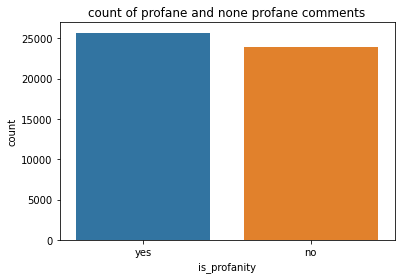

In [ ]:
sns.countplot(df.is_profanity)
plt.xlabel("is_profanity")
plt.title("count of profane and none profane comments")

In [ ]:
X = df.comment_body.values
y = df.is_profanity.values
print(type(X))

<class 'numpy.ndarray'>


In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(y)


[1 1 1 ... 0 0 0]


In [ ]:
print(y.shape)
print(X.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
max_words = 40000
max_len = 1500

tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)

In [ ]:
sequences = tok.texts_to_sequences(X_train)

In [ ]:
count = 0 
for i in sequences:
  print(len(i))
  count += 1 
  if count > 10:
    break

10
15
14
19
28
13
12
10
4
2
9


In [ ]:
sequence_matrix = sequence.pad_sequences(sequences, maxlen=max_len)
sequence_matrix[0]

array([    0,     0,     0, ...,    94,    73, 14860], dtype=int32)

In [ ]:
count = 0 
for i in sequence_matrix:
  print(i)
  count += 1 
  if count > 3: 
    break 

[    0     0     0 ...    94    73 14860]
[  0   0   0 ...   8 527   8]
[   0    0    0 ...    4  799 1170]
[  0   0   0 ...   3 983 106]


In [ ]:
with K.tf_ops.device('device:GPU:0'):
    model = Sequential()
    #max_words to 50 dim. so I will be putting 40000 words in to 50 dim. length of the word would be max_len
    model.add(Embedding(max_words, 50, input_length=max_len))
    model.add(LSTM(64))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    model_dir = 'saved_model/'
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    model_path = model_dir + "profanity_LSTM"
    
    checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
!mkdir -p saved_model
model.save('saved_model/profanity_LSTM') 

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1500, 50)          2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 2,046,337
Trainable params: 2,046,337
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist = model.fit(sequence_matrix, y_train, batch_size=128, epochs=10, validation_split=0.2, callbacks=[checkpoint, early_stopping])

Train on 31700 samples, validate on 7926 samples
Epoch 1/10
31700/31700 [==============================] - 623s 20ms/step - loss: 0.4051 - accuracy: 0.8080 - val_loss: 0.2462 - val_accuracy: 0.8983

Epoch 00001: val_loss improved from inf to 0.24621, saving model to saved_model/profanity_LSTM
Epoch 2/10
31700/31700 [==============================] - 630s 20ms/step - loss: 0.1424 - accuracy: 0.9508 - val_loss: 0.2168 - val_accuracy: 0.9195

Epoch 00002: val_loss improved from 0.24621 to 0.21679, saving model to saved_model/profanity_LSTM
Epoch 3/10
31700/31700 [==============================] - 630s 20ms/step - loss: 0.0707 - accuracy: 0.9777 - val_loss: 0.2316 - val_accuracy: 0.9233

Epoch 00003: val_loss did not improve from 0.21679
Epoch 4/10
31700/31700 [==============================] - 644s 20ms/step - loss: 0.0408 - accuracy: 0.9877 - val_loss: 0.2824 - val_accuracy: 0.9185

Epoch 00004: val_loss did not improve from 0.21679
Epoch 5/10
31700/31700 [==============================]

In [ ]:
sequences_test = tok.texts_to_sequences(X_test)
sequences_matrix_test = sequence.pad_sequences(sequences_test, maxlen=max_len)
print("Accuracy : %.4f" % (model.evaluate(sequences_matrix_test, y_test)[1]))

9907/9907 [==============================] - 69s 7ms/step
Accuracy : 0.9299


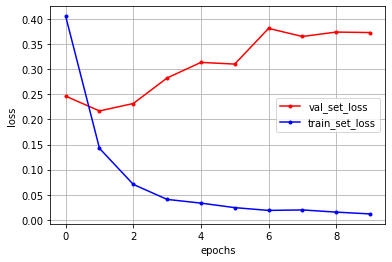

In [ ]:
y_vloss = hist.history['val_loss']
y_loss = hist.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

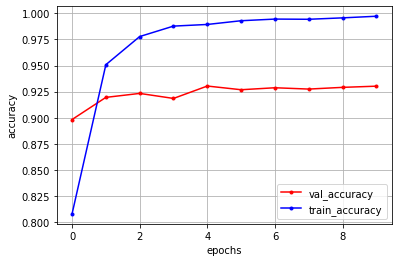

In [ ]:
y_vloss = hist.history['val_accuracy']
y_loss = hist.history['accuracy']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_accuracy')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.show()

In [ ]:
new_model = tf.keras.models.load_model("saved_model/profanity_LSTM")
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1500, 50)          2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 2,046,337
Trainable params: 2,046,337
Non-trainable params: 0
_________________________________________________________________


In [ ]:
string = ["Shit. I think I forgot my keys.", "I am happy.", "Are you sure?", "Fck. I think he should step down."]

In [ ]:
tokenized_string = tok.texts_to_sequences(string)

In [ ]:
tokenized_string

[[154, 6, 74, 6, 1195, 27, 4049],
 [6, 250, 488],
 [19, 12, 140],
 [18233, 6, 74, 36, 125, 956, 157]]

In [ ]:
tokenized_string = sequence.pad_sequences(tokenized_string, maxlen = 1500)

In [ ]:
tokenized_string

array([[   0,    0,    0, ..., 1195,   27, 4049],
       [   0,    0,    0, ...,    6,  250,  488],
       [   0,    0,    0, ...,   19,   12,  140],
       [   0,    0,    0, ...,  125,  956,  157]], dtype=int32)

In [ ]:
prediction = model.predict(tokenized_string)

In [ ]:
prediction

array([[9.4132811e-01],
       [8.0493570e-05],
       [4.8723463e-03],
       [9.9921918e-01]], dtype=float32)

In [ ]:
for word in prediction:
  if word > 0.5 : print("profanity ")
  else: print("not profanity") 

profanity 
not profanity
not profanity
profanity 
